# Submodule 2: Data Preprocessing and Quality Control


## Overview
In this module, we’ll cover essential steps for preprocessing and quality control of 16S rRNA sequencing data. Effective data preprocessing ensures that our analyses are based on high-quality data, minimizing errors and maximizing accuracy. This module will guide you through importing raw sequencing data, performing quality filtering, and removing potential errors such as chimeric sequences.

We’ll explain the **FastQ** file formats and use **DADA2** for quality assessment and feature extraction. This hands-on practice will import and process real data from the Nevada Wolfpack Study which we will use in the next module for downstream analyses.

<center>
    <img src="images/2.png" alt="2"/>
</center>

## Learning Objectives
+ Preprocess raw 16S rRNA sequencing data effectively.
+ Perform quality control checks on sequencing data.

## Import Sequencing Data

### Demultiplexing

Our starting point is demultiplexed samples sorted in individual files. Demultiplexing is a crucial step in processing high-throughput sequencing data when multiple samples are sequenced together in a single run (a process called multiplexing). Multiplexing allows researchers to save time and resources by sequencing multiple samples at once, but it introduces the need to sort, or "demultiplex," the data afterward.

In multiplexing, unique DNA "barcode" sequences are added to each sample before sequencing. During demultiplexing, these barcodes are used to identify which sequences belong to each original sample. The demultiplexing step occurs immediately after the sequencing machine outputs the raw data.

Demultiplexing software scans the data, recognizes the barcodes, and then separates sequences into individual files for each sample. Once demultiplexed, the data can be analyzed separately for each sample, moving on to further steps such as quality control, trimming, and chimera removal. Demultiplexing is typically performed by the sequencing platform's software and files of individual samples are given to the researcher. 

### Working with Our Samples

Working with microbiome data can be challenging. Traditional analysis methods cluster sequences based on similarity (operational taxonomic units (OTUs)), often missing the true biological diversity in the sample and sometimes lumping together different species. This can reduce the accuracy of the analysis, especially when studying complex microbial communities. Also, errors are often introduced during the sequencing process, such as substitutions (wrong bases) and chimera (sequences formed by two different DNA strands merging). These errors must be properly handled to avoid incorrect species identification. 

<center>
    <img src="images/dada2.png" alt="dada2" width="600"/>
</center>

We will use [DADA2](https://benjjneb.github.io/dada2/tutorial_1_8.html) to load, process, and quality control our sequencing files. DADA2 is a widely used software package in bioinformatics for analyzing microbial communities from DNA sequencing data and handling errors. It works particularly well in processing 16S rRNA data. 

### How DADA2 Works

DADA2 takes a new approach by attempting to resolve individual sequences down to the level of single-nucleotide differences while correcting for sequencing errors<sup>1</sup>. This approach is called **Amplicon Sequence Variants (ASVs)**, which are highly accurate sequences that represent actual biological diversity in the sample without clustering.

The DADA2 workflow includes several key steps:

 1. **Inspecting Read Quality Profiles:** Before processing, DADA2 allows us to visualize the quality scores across all sequences. Quality scores provide an estimate of the accuracy of each base call in a sequence. By inspecting these scores, we can identify where the quality drops, which helps determine appropriate trimming parameters.
 2. **Filtering and Trimming:** Low-quality sequences and ambiguous bases can introduce errors in downstream analysis. In this step, we set quality thresholds to remove reads that don’t meet quality standards. Trimming removes low-quality ends of reads based on quality scores, helping to retain only high-quality sequences for further analysis.
 3. **Learning Error Rates:** DADA2 builds a model of the specific error rates associated with the sequencing run. Since error patterns vary between sequencing technologies and even between runs, DADA2 analyzes a subset of data to estimate these unique error rates. This error model helps DADA2 accurately correct errors in the sequencing reads.
 4. **Inferring Sample Composition (ASV Inference):** Using the error model, DADA2 corrects sequencing errors to identify unique, true biological sequences known as Amplicon Sequence Variants (ASVs). ASVs provide finer resolution than Operational Taxonomic Units (OTUs) and often represent exact biological sequences rather than clustered approximations.
 5. **Merging Paired Reads:** Since we are using paired-end sequencing, this step merges the forward and reverse reads that cover overlapping regions of the same DNA fragment. The merged reads typically provide higher accuracy by combining information from both ends, but reads that fail to overlap are discarded.
 6. **Constructing a Sequence Table:** After ASVs are identified, DADA2 constructs a sequence table, which is a matrix of samples and their ASV counts. This table serves as the primary data structure for downstream analysis, showing how many times each ASV appears in each sample.
 7. **Removing Chimeras:** Chimeric sequences are artifacts from PCR amplification, formed by combining segments from different DNA templates. DADA2 identifies these artificial sequences by comparing ASVs and removes them to reduce false positives in microbial identification.
 8. **Tracking Reads Through the Pipeline:** Throughout the pipeline, DADA2 tracks the number of reads retained at each step. This read-tracking helps to monitor data quality and determine where reads may have been lost, providing a quality control check on each processing stage.
 9. **Assigning Taxonomy:** After obtaining high-quality ASVs, DADA2 compares them to a reference database (e.g., SILVA, Greengenes) to assign taxonomic labels. This step allows us to identify the microbial taxa present in each sample down to species, genus, or other taxonomic levels, depending on the reference database used.

This process gives us highly accurate and reproducible results. We will start by installing and loading DADA2 and necessary packages.

In [1]:
#Install the DADA2 and other packages
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("dada2", quietly = TRUE)) {
    BiocManager::install("dada2")
}

if (!requireNamespace("devtools", quietly = TRUE)) {
    install.packages("devtools")
}

if (!requireNamespace("patchwork", quietly = TRUE)) {
    devtools::install("patchwork")
}

In [3]:
#Load the packages
library(dada2)
library(ggplot2)
library(patchwork)

Loading required package: Rcpp



Our sequencing files are stored in FASTQ format, a common file type for sequencing data. Each entry (or sequence) in a FASTQ file contains four lines: the sequence identifier, the DNA sequence, a separator, and a quality score line. This format is compact and efficient, making it essential for storing large-scale sequencing data.

<center>
    <img src="images/fastq.png" alt="fastq" width="900"/>
</center>

FASTQ files follow the same format with each sequence entry:
 1. **Sequence Identifier:** Starts with an "@" symbol, followed by a unique identifier for the sequence. It may also contain additional details, such as the instrument used and the read number.
 2. **DNA Sequence:** The actual sequence of DNA bases (A, T, C, G) observed in the sample. The length of this line is equal to the number of bases sequenced.
 3. **Separator Line:** A "+" symbol acts as a separator between the sequence and its quality scores.
 4. **Quality Scores:** A string of characters representing the quality of each base in the sequence. Each character encodes a [Phred quality score](https://en.wikipedia.org/wiki/Phred_quality_score), where higher scores indicate more confidence in the accuracy of the base call. The quality string is the same length as the sequence line.

Now we will download our data and import it with DADA2.

In [ ]:
# Download data directory from storage bucket
system("mkdir -p datach/fastq")
system("aws s3 cp s3://nigms-module-data/fastqs/ datach/fastq --recursive")

In [4]:
# Check files
path <- "datach/fastquz/newFastq"
list.files(path)

[1] "WP-11O29_S66_L001_R1_001.fastq" "WP-11O29_S66_L001_R2_001.fastq"
 [3] "WP-1641C_S68_L001_R1_001.fastq" "WP-1641C_S68_L001_R2_001.fastq"
 [5] "WP-1J0A0_S50_L001_R1_001.fastq" "WP-1J0A0_S50_L001_R2_001.fastq"
 [7] "WP-3GH4E_S51_L001_R1_001.fastq" "WP-3GH4E_S51_L001_R2_001.fastq"
 [9] "WP-4SP0U_S57_L001_R1_001.fastq" "WP-4SP0U_S57_L001_R2_001.fastq"
[11] "WP-6RCV3_S39_L001_R1_001.fastq" "WP-6RCV3_S39_L001_R2_001.fastq"
[13] "WP-7FAEC_S47_L001_R1_001.fastq" "WP-7FAEC_S47_L001_R2_001.fastq"
[15] "WP-8SXNH_S53_L001_R1_001.fastq" "WP-8SXNH_S53_L001_R2_001.fastq"
[17] "WP-8V6E3_S72_L001_R1_001.fastq" "WP-8V6E3_S72_L001_R2_001.fastq"
[19] "WP-95020_S58_L001_R1_001.fastq" "WP-95020_S58_L001_R2_001.fastq"
[21] "WP-9ZJJI_S55_L001_R1_001.fastq" "WP-9ZJJI_S55_L001_R2_001.fastq"
[23] "WP-ATJLX_S75_L001_R1_001.fastq" "WP-ATJLX_S75_L001_R2_001.fastq"
[25] "WP-DFG11_S74_L001_R1_001.fastq" "WP-DFG11_S74_L001_R2_001.fastq"
[27] "WP-EC5AP_S42_L001_R1_001.fastq" "WP-EC5AP_S42_L001_R2_001.fastq"
[29] "WP-G375R_S73_L001_R1_001.fastq" "WP-G375R_S73_L001_R2_001.fastq"
[31] "WP-G9EBL_S40_L001_R1_001.fastq" "WP-G9EBL_S40_L001_R2_001.fastq"
[33] "WP-J06MK_S31_L001_R1_001.fastq" "WP-J06MK_S31_L001_R2_001.fastq"
[35] "WP-J0B3X_S33_L001_R1_001.fastq" "WP-J0B3X_S33_L001_R2_001.fastq"
[37] "WP-KM8BK_S62_L001_R1_001.fastq" "WP-KM8BK_S62_L001_R2_001.fastq"
[39] "WP-KXGT6_S37_L001_R1_001.fastq" "WP-KXGT6_S37_L001_R2_001.fastq"
[41] "WP-MRCZG_S36_L001_R1_001.fastq" "WP-MRCZG_S36_L001_R2_001.fastq"
[43] "WP-QIGEC_S59_L001_R1_001.fastq" "WP-QIGEC_S59_L001_R2_001.fastq"
[45] "WP-RAJES_S35_L001_R1_001.fastq" "WP-RAJES_S35_L001_R2_001.fastq"
[47] "WP-RPV50_S49_L001_R1_001.fastq" "WP-RPV50_S49_L001_R2_001.fastq"
[49] "WP-SUFNU_S34_L001_R1_001.fastq" "WP-SUFNU_S34_L001_R2_001.fastq"
[51] "WP-TDY7G_S32_L001_R1_001.fastq" "WP-TDY7G_S32_L001_R2_001.fastq"
[53] "WP-U4XI6_S44_L001_R1_001.fastq" "WP-U4XI6_S44_L001_R2_001.fastq"
[55] "WP-UIXW3_S45_L001_R1_001.fastq" "WP-UIXW3_S45_L001_R2_001.fastq"
[57] "WP-X576L_S56_L001_R1_001.fastq" "WP-X576L_S56_L001_R2_001.fastq"
[59] "WP-X803O_S69_L001_R1_001.fastq" "WP-X803O_S69_L001_R2_001.fastq"
[61] "WP-XDI0I_S65_L001_R1_001.fastq" "WP-XDI0I_S65_L001_R2_001.fastq"
[63] "WP-YF6XT_S61_L001_R1_001.fastq" "WP-YF6XT_S61_L001_R2_001.fastq"
[65] "WP-YRYYF_S67_L001_R1_001.fastq" "WP-YRYYF_S67_L001_R2_001.fastq"
[67] "WP-YY8WG_S38_L001_R1_001.fastq" "WP-YY8WG_S38_L001_R2_001.fastq"
[69] "WP-Z01LM_S43_L001_R1_001.fastq" "WP-Z01LM_S43_L001_R2_001.fastq"

In [6]:
# Forward and reverse fastq filenames have format: SAMPLENAME_L001_R1_001.fastq and SAMPLENAME_L001_R2_001.fastq
fnFs <- sort(list.files(path, pattern="_L001_R1_001.fastq", full.names = TRUE))
fnRs <- sort(list.files(path, pattern="_L001_R2_001.fastq", full.names = TRUE))

In [8]:
# Extract sample names
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)

Check to make sure our sample names are correct.

In [11]:
# Display sample names and number of samples
cat("Sample names:\n")
cat(sample.names, sep = "\n")
cat("There are", length(sample.names), "samples")

Sample names:
WP-11O29
WP-1641C
WP-1J0A0
WP-3GH4E
WP-4SP0U
WP-6RCV3
WP-7FAEC
WP-8SXNH
WP-8V6E3
WP-95020
WP-9ZJJI
WP-ATJLX
WP-DFG11
WP-EC5AP
WP-G375R
WP-G9EBL
WP-J06MK
WP-J0B3X
WP-KM8BK
WP-KXGT6
WP-MRCZG
WP-QIGEC
WP-RAJES
WP-RPV50
WP-SUFNU
WP-TDY7G
WP-U4XI6
WP-UIXW3
WP-X576L
WP-X803O
WP-XDI0I
WP-YF6XT
WP-YRYYF
WP-YY8WG
WP-Z01LM
There are 35 samples

In [15]:
# Save our data
saveRDS(sample.names, file = 'sampleNames.rds')

## 2. Data Preprocessing and Quality Control

### Read Quality Score
We will first look at the quality of the individual bases in the reads by pulling the Phred score for each read in a sample. The heatmap produced shows the frequency of each quality score at each base over all the reads for a given sample. The green line represents the median with orange lines representing quartiles. 

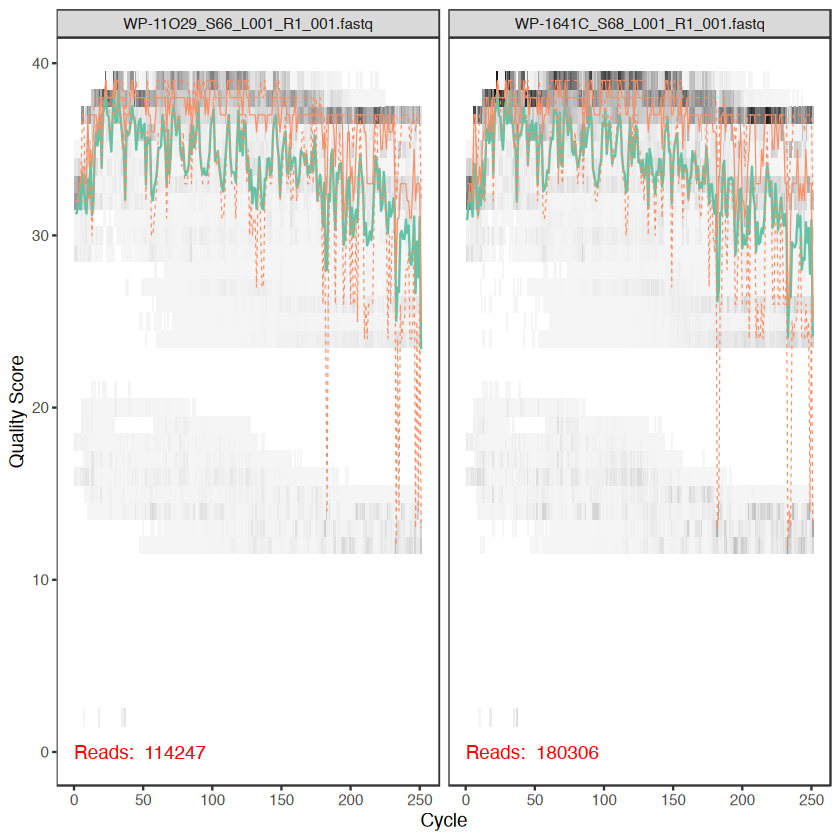

In [17]:
# View quality profiles of forward reads for the first 2 samples
plotQualityProfile(fnFs[1:2])

In [19]:
# We can create a plot for all of the samples and
p1 = plotQualityProfile(fnFs) +
  ggtitle('Forward Reads')

p2 = plotQualityProfile(fnRs)+
  ggtitle('Reverse Reads')


In [21]:
# Save the plot
ggsave('viz_data/plotQualityProfile.png', plot = p1 + p2, width = 18, height = 12, units = 'in', dpi = 600)

We can manually visualize our quality profiles for all of the samples (plotQualityProfile.png) in the viz_data folder. We can see that the quality starts off pretty well and slowly decreases toward the end of the read.

In [ ]:
# View quality profiles of reverse reads for the first 2 samples
plotQualityProfile(fnRs[1:2])

Reverse reads often have much lower quality scores. This is okay since DADA2 incorperates quailty scores in it's error modles. However, we will still trim some of the poor quality reads to improve the algorithm. 

### Filter and Trim

In [13]:
# Place filtered files in filtered/ subdirectory
filtFs <- file.path(path, "filtered", paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path(path, "filtered", paste0(sample.names, "_R_filt.fastq.gz"))
names(filtFs) <- names(filtRs) <- sample.names

In [15]:
# Set trimming standards first
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, truncLen=c(200,130),
                     maxN=0, maxEE=c(2,5), trimLeft = c(0,0), truncQ=2, rm.phix=TRUE,
                     compress=TRUE) 


Creating output directory: datach/fastquz/newFastq/filtered



In [17]:
# View outputs
head(out)

,reads.in,reads.out
WP-11O29_S66_L001_R1_001.fastq,114247,39363
WP-1641C_S68_L001_R1_001.fastq,180306,63123
WP-1J0A0_S50_L001_R1_001.fastq,118458,41544
WP-3GH4E_S51_L001_R1_001.fastq,105493,37698
WP-4SP0U_S57_L001_R1_001.fastq,245187,83598
WP-6RCV3_S39_L001_R1_001.fastq,114269,40530


Due to a recent system update on the MiSeq, the sequencing run was inadvertently over-clustered, producing an excess of low-quality reads. These low-quality reads are removed during the initial trimming step, significantly reducing read count. This is a common outcome in over-clustered runs, where the high read quantity does not translate to high-quality data, and substantial trimming is necessary to retain only reliable sequences.

### Learn the Error Rates
DADA2 uses a machine-learning algorithm to model the errors in every data set. Every sequencing run has its own error profile, which DADA2 accounts for by creating an error model specific to each dataset.  DADA2 makes a "best guess" and iteratively refines its model by inferring sample composition. These steps may take a few minutes to run.

In [ ]:
# Error model for forward reads
errF <- learnErrors(filtFs, multithread=TRUE)

In [ ]:
# Error model for reverse reads
errR <- learnErrors(filtRs, multithread=TRUE)

In [ ]:
# Save our outputs
saveRDS(errF,file="errF.rds")
saveRDS(errR,file="errR.rds")

<details>
<summary>If you are coming back to this module, reload your saved data here.</summary>
<br>
If you are coming back to this module, you can load your saved data instead of rerunning. Use the following R code to upload saved data.
    
```r
errF <- readRDS("errF.rds")
errR <- readRDS("errR.rds")

```
</details>

We can now plot the estimated error rates. These plots displays the observed error rates across various quality scores for each base position in the reads (A, C, G, T). It allows us to compare the empirical error rates (from the actual data) to the estimated error rates (based on the model DADA2 has learned represented in a grey line).

In [ ]:
# Plot forward reads estimated error rates
plotErrors(errF, nominalQ=TRUE) +
  ggtitle('errF')

In [ ]:
# Plot reverse reads estimated error rates
plotErrors(errR, nominalQ = TRUE) +
  ggtitle('errR')

### Sample Inference

We will now use DADA2's learned error rates and identify exact sequence variants (ASV) while removing likely errors. 

In [ ]:
# Creating DADA object
dadaFs <- dada(filtFs, err=errF, multithread=TRUE) # filtered reads in unqiue sequences
dadaRs <- dada(filtRs, err=errR, multithread=TRUE)

In [ ]:
# Review DADA object
dadaFs[[1]]

### Merge paired reads
This step combines forward and reverse reads from paired-end sequencing to reconstruct the full-length sequences of the DNA fragments.

In [ ]:
# Combine the forward and reverse reads into one
mergers <- mergePairs(dadaFs, filtFs, dadaRs, filtRs, verbose=TRUE)
# Inspect the merger data.frame from the first sample
head(mergers[[1]])

### Construct sequence table

We can now constuct the ASV table. This table is a matrix of samples (rows) and each ASV identified (columns). 

In [ ]:
# View the dimensions of our merged samples 
seqtab  <- makeSequenceTable(mergers)
dim(seqtab)

Our table contains 42 samples and 7101 ASVs. Now let's view the lengths of the variants. 

In [ ]:
# Inspect distribution of sequence lengths
table(nchar(getSequences(seqtab))) # the length should be around 250

### Remove Chimeras

DADA2's error model corrects for substitutions and indels, but not Chimeras (two different DNA strands megred together). Chimeras are easier to identify in ASVs, as opposed to OTUs, because of there exact sequences.

In [ ]:
# Remove chimeras
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", multithread=TRUE, verbose=TRUE)

In [ ]:
# New sequence table
dim(seqtab.nochim)
# Divide the new number of ASVs by the first table.
# This shows us what percentage was removed
sum(seqtab.nochim)/sum(seqtab)

Here we can see that Chimeras accounted for ~10% of the merged secuence reads.

In [ ]:
# Save our data
saveRDS(seqtab.nochim, "seqtabnochim.rds")

### Track reads through the pipeline

Let's construct a summary table of our steps to see how many reads were removed in the cleaning process. 

In [ ]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim),
               final_perc_reads_retained=round(rowSums(seqtab.nochim)/out[,1]*100, 1))
# formatting table before writting to file
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nonchim","percent")
rownames(track) <- sample.names
track
write.table(track, "viz_data/read-count-tracking.txt", quote=FALSE, sep="\t")

We retained ~25-30% of our original reads! This is likely due to the poor quality we saw at the beginning. Although we now have much less data to work with, it is high quality. 

### Read in taxonomy

The last step in this model is to read in a taxonomy database. We must first select a database. Two of the most commonly used are Greengenes and SILVA, each with its strengths and weaknesses.
 + **Greengenes<sup>2</sup>** is a chimera-checked 16S rRNA gene database. It provides chimera screening, standard alignment, and taxonomic classification using multiple published taxonomies. Its most recent update was on July 03, 2017.
 + **[SILVA](https://www.arb-silva.de/documentation/release-138.1/)<sup>3-4</sup>** is a high quality ribosomal RNA database. It is a comprehensive and quality-controlled database for up-to-date ribosomal RNA sequences. Additionally, SILVA also provides many other tools like alignment, phylogenetic tree classification, and probe/primer matching. It was last updated on August 27, 2020.

Since our data has chimeras removed and we want the most up-to-date analysis, we will use SILVA.

In [ ]:
# Read in Taxonomy
taxa <- assignTaxonomy(seqtab.nochim, "tax/silva_nr99_v138.1_train_set.fa.gz", multithread=TRUE)
taxa <- addSpecies(taxa, "tax/silva_species_assignment_v138.1.fa.gz")

In [ ]:
# Let's take a look
taxa.print <- taxa # Removing sequence rownames for display only
rownames(taxa.print) <- NULL
head(taxa.print)

#### Adding Controls

Microbime studies often include mock and/or blank controls to help identify and mitigate possible contamination, ensuring the accuracy and reliability of the data.

 + **Mock Controls:** These are samples with a known microbial community composition, often with a defined mix of microbial strains in known proportions. By including mock controls, researchers can verify the performance of the sequencing pipeline and taxonomic assignment tools. If the analysis accurately identifies the species and proportions in the mock community, it provides confidence that the methods are performing correctly. Any discrepancies may indicate biases in the sequencing or analysis process that should be addressed.
 + **Blank Controls:** These are negative controls that contain no added DNA. Blank controls help detect potential contamination from reagents, the lab environment, or equipment. Since microbial DNA is often present at very low concentrations, contamination can skew results, especially for low-biomass samples. If microbial sequences appear in blank controls, it could indicate contamination, and researchers can account for this by removing these sequences from experimental samples.

Although our study does not have these controls, incorporating both mock and blank controls in the study design can boost quality control. It helps distinguish true biological signals from artifacts introduced during sample processing or sequencing. 

In [ ]:
# Save our data
saveRDS(taxa, "taxa.rds")

## Quiz

In [19]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./questions/Quiz_Submodule2.html" width=100% height=250></iframe>')

## Conclusion
In this module, we took a comprehensive journey from the initial stages of data acquisition through taxonomic assignment. We began by downloading and exploring the survey data to understand the metadata associated with each sample. Following this, we downloaded the raw sequencing FASTQ files and preprocessed them using the DADA2 pipeline, which allowed us to perform quality control, error correction, and sequence denoising, resulting in high-quality amplicon sequence variants (ASVs). Finally, we assigned taxonomy to the ASVs using a reference database, enabling us to identify and categorize the microbial communities present in our samples. This workflow provides a foundational dataset ready for downstream analysis, such as community composition comparisons and diversity assessments in the next module.

## Clean up
Please remember to shut down your Sagemaker instance. <br><br>

## References

1. Callahan BJ, McMurdie PJ, Rosen MJ, Han AW, Johnson AJA, Holmes SP. 2016. DADA2: High-resolution sample inference from Illumina amplicon data. Nat Methods 13:581–583. doi:10.1038/nmeth.3869
2. DeSantis TZ, Hugenholtz P, Larsen N, Rojas M, Brodie EL, Keller K, Huber T, Dalevi D, Hu P, Andersen GL. Greengenes, a chimera-checked 16S rRNA gene database and workbench compatible with ARB. Appl Environ Microbiol. 2006 Jul;72(7):5069-72. doi: 10.1128/AEM.03006-05. PMID: 16820507; PMCID: PMC1489311.
3. Quast C, Pruesse E, Yilmaz P, Gerken J, Schweer T, Yarza P, Peplies J, Glöckner FO (2013) The SILVA ribosomal RNA gene database project: improved data processing and web-based tools. Nucl. Acids Res. 41 (D1): D590-D596.
4. Yilmaz P, Parfrey LW, Yarza P, Gerken J, Pruesse E, Quast C, Schweer T, Peplies J, Ludwig W, Glöckner FO (2014) The SILVA and "All-species Living Tree Project (LTP)" taxonomic frameworks. Nucl. Acids Res. 42:D643-D648